In [8]:
import argparse
import os
import time
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import CIFAR10, CIFAR100
from tqdm import tqdm

## 
# plot.py
import functools

import matplotlib
import matplotlib.pyplot as plt
import datetime 

import scipy.stats
from sklearn.metrics import auc, roc_curve

##
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

In [9]:
# for vgg19, CIFAR-10
''' 
lr = 0.02
epochs = 25
n_shadows = 64
shadow_id = -1 
model = "vgg19"
dataset = "cifar10"
pkeep = 0.5
savedir = f"exp/{model}_{dataset}"
debug = True
'''

' \nlr = 0.02\nepochs = 25\nn_shadows = 64\nshadow_id = -1 \nmodel = "vgg19"\ndataset = "cifar10"\npkeep = 0.5\nsavedir = "exp/cifar10"\ndebug = True\n'

In [52]:
# for vgg19, CIFAR-100
lr = 0.025
epochs = 25
n_shadows = 64
shadow_id = -1 
model = "vgg19"
dataset = "cifar100"
pkeep = 0.5
savedir = f"exp/{model}_{dataset}"
debug = True

In [11]:
# inference
n_queries = 2

In [12]:
seed = 1583745484

# Train victim model

In [40]:
# Dataset
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)
torch.manual_seed(seed)
datadir = Path().home() / "dataset"

if dataset == "cifar10":
    print("import cifar10...")
    train_ds = CIFAR10(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR10(root=datadir, train=False, download=True, transform=test_transform)
elif dataset == "cifar100":
    print("import cifar100...")
    train_ds = CIFAR100(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR100(root=datadir, train=False, download=True, transform=test_transform)
else:
    raise ValueError("undefined dataset")

# train_ds, eval_ds = random_split(train_ds, [0.8, 0.2])

import cifar100...
Files already downloaded and verified
Files already downloaded and verified


In [41]:
size = len(train_ds)
np.random.seed(seed)

In [42]:
size

50000

In [43]:
keep = np.random.choice(size, size=int(pkeep * size), replace=False)
keep.sort()

keep_bool = np.full((size), False)
keep_bool[keep] = True

In [44]:
train_ds = torch.utils.data.Subset(train_ds, keep)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

In [45]:
len(train_ds) # 50%(pkeep) of training dataset

25000

In [23]:
def network(arch: str, pretrained_: bool):
    print(f'arch: {arch}, pretrained: {pretrained_}') 
    
    # https://pytorch.org/vision/stable/models.html
    TORCHVISION_MODELS = ['resnet18', 'resnet50', 'resnet101', 'vgg16', 'vgg19', 'densenet121', 
                          'wide_resnet50_2', 'wide_resnet101_2',
                          'densenet201', 'mobilenet_v2', 'inception_v3', 
                          'efficientnet_b0', 'efficientnet_b7', 
                          'squeezenet1_0', 'alexnet', 'googlenet', 'shufflenet_v2_x1_0']
    
    # https://github.com/huggingface/pytorch-image-models
    PYTORCH_IMAGE_MODELS = ['vit_base_patch16_224', 'vit_large_patch16_224', 'deit_base_patch16_224',
                        'convnext_base', 'convnext_large']
    
    if arch in TORCHVISION_MODELS:
        model = models.__dict__[arch](pretrained=pretrained_)
    elif arch in PYTORCH_IMAGE_MODELS:
        model = timm.create_model(arch, pretrained=pretrained_)
    else:
        raise ValueError(f"Model {model_name} not available.")
        
    if dataset == "cifar10":
        print("modify output layers for cifar10...")
        # for VGG-19
        model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=10)
        
    elif dataset == "cifar100":
        print("modify output layers for cifar100...")
        model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=100)
        
    else:
        raise ValueError("undefined dataset")    
        
    return model


@torch.no_grad()
def get_acc(model, dl):
    acc = []
    for x, y in dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        acc.append(torch.argmax(model(x), dim=1) == y)
    acc = torch.cat(acc)
    acc = torch.sum(acc) / len(acc)

    return acc.item()

In [24]:
m = network(model, pretrained_=True)
m = m.to(DEVICE)
print(m)

arch: vgg19, pretrained: True
modify output layers for cifar100...
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)

In [25]:
optim = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

In [26]:
# wandb.init(project="lira", mode="disabled" if debug else "online")
# wandb.config.update(args)

for epoch in range(epochs):
    m.train()
    loss_total = 0
    pbar = tqdm(train_dl)
    for itr, (x, y) in enumerate(pbar):
        x, y = x.to(DEVICE), y.to(DEVICE)

        outputs = m(x)
        loss = F.cross_entropy(outputs, y)
        loss_total += loss
        
        pbar.set_postfix_str(f"loss: {loss:.2f}")
        optim.zero_grad()
        loss.backward()
        optim.step()
    sched.step()

    test_acc = get_acc(m, test_dl)
    print(f"[Epoch {epoch}] Test Accuracy: {test_acc:.4f}")
    # wandb.log({"loss": loss_total / len(train_dl)})

print(f"[test] acc_test: {get_acc(m, test_dl):.4f}")
# wandb.log({"acc_test": get_acc(m, test_dl)})

savedir_victim = os.path.join(savedir, "victim")
os.makedirs(savedir_victim, exist_ok=True)
np.save(savedir_victim + "/keep.npy", keep_bool)
torch.save(m.state_dict(), savedir_victim + "/model.pt")

100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 28.81it/s, loss: 2.97]


[Epoch 0] Test Accuracy: 0.2516


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.00it/s, loss: 2.42]


[Epoch 1] Test Accuracy: 0.2911


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.74it/s, loss: 2.32]


[Epoch 2] Test Accuracy: 0.3730


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.11it/s, loss: 2.03]


[Epoch 3] Test Accuracy: 0.4227


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.22it/s, loss: 1.71]


[Epoch 4] Test Accuracy: 0.4006


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 31.04it/s, loss: 1.79]


[Epoch 5] Test Accuracy: 0.4656


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.91it/s, loss: 1.51]


[Epoch 6] Test Accuracy: 0.4718


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.59it/s, loss: 2.19]


[Epoch 7] Test Accuracy: 0.4783


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.82it/s, loss: 1.22]


[Epoch 8] Test Accuracy: 0.4988


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.75it/s, loss: 1.76]


[Epoch 9] Test Accuracy: 0.5325


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.98it/s, loss: 1.74]


[Epoch 10] Test Accuracy: 0.5295


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.78it/s, loss: 1.28]


[Epoch 11] Test Accuracy: 0.5380


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.07it/s, loss: 1.01]


[Epoch 12] Test Accuracy: 0.5655


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.76it/s, loss: 1.20]


[Epoch 13] Test Accuracy: 0.5713


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.89it/s, loss: 0.73]


[Epoch 14] Test Accuracy: 0.5912


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.13it/s, loss: 0.72]


[Epoch 15] Test Accuracy: 0.5911


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.73it/s, loss: 0.55]


[Epoch 16] Test Accuracy: 0.6069


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.07it/s, loss: 0.52]


[Epoch 17] Test Accuracy: 0.6261


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.73it/s, loss: 0.60]


[Epoch 18] Test Accuracy: 0.6205


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 30.20it/s, loss: 0.41]


[Epoch 19] Test Accuracy: 0.6309


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.38it/s, loss: 0.30]


[Epoch 20] Test Accuracy: 0.6347


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.83it/s, loss: 0.65]


[Epoch 21] Test Accuracy: 0.6369


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.48it/s, loss: 0.52]


[Epoch 22] Test Accuracy: 0.6430


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.36it/s, loss: 0.21]


[Epoch 23] Test Accuracy: 0.6416


100%|███████████████████████████████████████████████████████████████████| 196/196 [00:06<00:00, 29.62it/s, loss: 0.11]


[Epoch 24] Test Accuracy: 0.6425
[test] acc_test: 0.6439


# Inference

In [28]:
# inference from victim model
# run below script at ~/lira-pytorch_

# CUDA_VISIBLE_DEVICES=0 python3 -u inference.py --savedir=exp/cifar10/victim --model vgg19 --mode eval &> logs/inference/log_victim

In [27]:
# inference from shadow models
# run below script at ~/lira-pytorch_

# bash scripts/run_infer-vgg19_n_shadows_64.sh > run_infer-vgg19_n_shadows_64.log 2>&1 &

# Computer score (logit scaling; Ø(p) = log(p/(1-p)) )

In [47]:
# run below script at ~/lira-pytorch_
# compute scores for both victim model and shadow models

# python3 score.py --dataset cifar100 --savedir exp/vgg19_cifar100 --mode eval

# Evaluate: 
## 1. generate distributions (Q_in, Q_out), 
## 2. then perform online/offline attack by estimating likeliehood ratio (Λ)

In [48]:
if dataset == "cifar10":
    print("import cifar10...")
    _train_ds = CIFAR10(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR10(root=datadir, train=False, download=True, transform=test_transform)
elif dataset == "cifar100":
    print("import cifar100...")
    _train_ds = CIFAR100(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR100(root=datadir, train=False, download=True, transform=test_transform)
else:
    raise ValueError("undefined dataset")

torch.manual_seed(seed)
_, eval_ds = random_split(_train_ds, [0.8, 0.2])

import cifar100...
Files already downloaded and verified
Files already downloaded and verified


In [49]:
print("train_ds: ", len(train_ds)) # for training victim model T among T + S 
print("eval_ds: ", len(eval_ds))

### desirable output: 

# train_ds:  25000 (50%(or pkeep) of training dataset for victim model)
# eval_ds:  10000

train_ds:  25000
eval_ds:  10000


In [55]:
# load scores from victim model
train_indices = set(train_ds.indices) # = T 
eval_in_train = [True if idx in train_indices else False for idx in eval_ds.indices] # T2
print("eval_in_train: ", sum(eval_in_train))

v_scores = np.load(os.path.join(savedir, "victim", "scores.npy"))
v_keep = np.array(eval_in_train) # eval_ds ^ train_ds; 

v_scores_r = v_scores.reshape(1, *v_scores.shape)
v_keep_r = v_keep.reshape(1, v_scores.shape[0])
v_scores = v_scores_r
v_keep = v_keep_r

print("v_scores: ", v_scores.shape)
print("v_keep: ", v_keep.shape)

eval_in_train:  5118
v_scores:  (1, 10000, 2)
v_keep:  (1, 10000)


In [56]:
v_scores

array([[[ 0.22144672,  3.43347436],
        [ 2.93079562,  1.41710158],
        [ 4.50150441,  4.20019691],
        ...,
        [ 6.90829848,  7.48802251],
        [ 4.79561377,  3.05611562],
        [-5.16042448, -4.72585172]]])

In [57]:
v_keep

array([[False,  True,  True, ...,  True,  True, False]])

In [58]:
# load scores from shadow models
def load_data():
    """
    Load our saved scores and then put them into a big matrix.
    """
    global scores, keep
    scores = []
    keep = []

    paths = []

    for path in os.listdir(savedir):
        if path == "victim":
            continue
        paths.append(path)
        
        s_ = np.load(os.path.join(savedir, path, "scores.npy"))
        # k_ = np.load(os.path.join(savedir, path, "keep.npy"))
        k_ = np.zeros((10000,), dtype=bool)

        scores.append(s_)
        keep.append(k_)
        # print("s_: ", s_.shape)
        # print("k_: ", k_.shape)

    print("paths: ", paths)
    
    scores = np.array(scores)
    keep = np.array(keep)

    return scores, keep

In [59]:
scores, keep = load_data()

print("scores: ", scores.shape)
# print(scores)
print("keep: ", keep.shape) # False for all;
# print(keep)

paths:  ['11', '29', '23', '54', '30', '47', '5', '8', '40', '37', '2', '59', '53', '24', '16', '61', '12', '18', '57', '20', '39', '6', '44', '33', '49', '1', '34', '43', '27', '50', '62', '15', '25', '52', '58', '60', '17', '3', '9', '36', '41', '4', '46', '31', '10', '55', '22', '28', '51', '26', '14', '63', '42', '35', '48', '0', '32', '45', '38', '7', '19', '13', '21', '56']
scores:  (64, 10000, 2)
keep:  (64, 10000)


In [60]:
np.isnan(scores).any()

False

In [61]:
def sweep(score, x):
    """
    Compute a ROC curve and then return the FPR, TPR, AUC, and ACC.
    """
    fpr, tpr, _ = roc_curve(x, -score)
    acc = np.max(1 - (fpr + (1 - tpr)) / 2)
    return fpr, tpr, auc(fpr, tpr), acc


def do_plot(fn, keep, scores, check_keep, check_scores, ntest, legend="", metric="auc", sweep_fn=sweep, **plot_kwargs):
    """
    Generate the ROC curves by using ntest models as test models and the rest to train.
    """

    prediction, answers = fn(keep, scores, check_keep, check_scores)

    fpr, tpr, auc, acc = sweep_fn(np.array(prediction), np.array(answers, dtype=bool))

    low = tpr[np.where(fpr < 0.001)[0][-1]]

    print("Attack %s   AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f" % (legend, auc, acc, low))

    metric_text = ""
    if metric == "auc":
        metric_text = "auc=%.3f" % auc
    elif metric == "acc":
        metric_text = "acc=%.3f" % acc

    plt.plot(fpr, tpr, label=legend + metric_text, **plot_kwargs)
    return (acc, auc)

In [62]:
def generate_ours(keep, scores, check_keep, check_scores, in_size=100000, out_size=100000, fix_variance=False):
    """
    Fit a two predictive models using keep and scores in order to predict
    if the examples in check_scores were training data or not, using the
    ground truth answer from check_keep.
    """
    dat_in = []
    dat_out = []

    # iterate data points (x, y).
    for j in range(scores.shape[1]):
        dat_in.append(scores[keep[:, j], j, :])
        dat_out.append(scores[~keep[:, j], j, :])

    in_size = min(min(map(len, dat_in)), in_size)
    out_size = min(min(map(len, dat_out)), out_size)

    dat_in = np.array([x[:in_size] for x in dat_in])
    dat_out = np.array([x[:out_size] for x in dat_out])

    mean_in = np.median(dat_in, 1)
    mean_out = np.median(dat_out, 1)

    if fix_variance:
        std_in = np.std(dat_in)
        std_out = np.std(dat_in)
    else:
        std_in = np.std(dat_in, 1)
        std_out = np.std(dat_out, 1)

    prediction = []
    answers = []
    for ans, sc in zip(check_keep, check_scores):
        print(ans)
        print(sc)
        
        pr_in = -scipy.stats.norm.logpdf(sc, mean_in, std_in + 1e-30)
        pr_out = -scipy.stats.norm.logpdf(sc, mean_out, std_out + 1e-30)
        score = pr_in - pr_out

        prediction.extend(score.mean(1))
        answers.extend(ans) ### 

    return prediction, answers


def generate_ours_offline(keep, scores, check_keep, check_scores, in_size=100000, out_size=100000, fix_variance=False):
    """
    Fit a single predictive model using keep and scores in order to predict
    if the examples in check_scores were training data or not, using the
    ground truth answer from check_keep.
    """
    dat_in = []
    dat_out = []

    for j in range(scores.shape[1]):
        dat_in.append(scores[keep[:, j], j, :])
        dat_out.append(scores[~keep[:, j], j, :])

    out_size = min(min(map(len, dat_out)), out_size)

    dat_out = np.array([x[:out_size] for x in dat_out])

    mean_out = np.median(dat_out, 1)

    if fix_variance:
        std_out = np.std(dat_out)
    else:
        std_out = np.std(dat_out, 1)

    prediction = []
    answers = []
    for ans, sc in zip(check_keep, check_scores):
        score = scipy.stats.norm.logpdf(sc, mean_out, std_out + 1e-30)

        prediction.extend(score.mean(1))
        answers.extend(ans)
    return prediction, answers


def generate_global(keep, scores, check_keep, check_scores):
    """
    Use a simple global threshold sweep to predict if the examples in
    check_scores were training data or not, using the ground truth answer from
    check_keep.
    """
    prediction = []
    answers = []
    for ans, sc in zip(check_keep, check_scores):
        prediction.extend(-sc.mean(1))
        answers.extend(ans)

    return prediction, answers

Attack Ours (offline)
   AUC 0.6717, Accuracy 0.6513, TPR@0.1%FPR of 0.0229
Attack Ours (offline, fixed variance)
   AUC 0.6800, Accuracy 0.6448, TPR@0.1%FPR of 0.0395
Attack Global threshold
   AUC 0.6618, Accuracy 0.6488, TPR@0.1%FPR of 0.0010


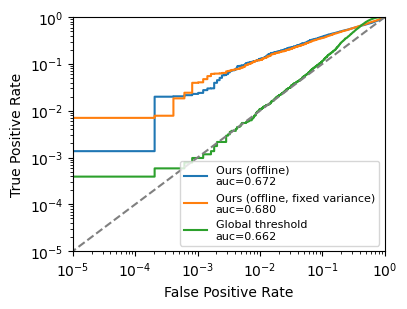

In [63]:
# def fig_fpr_tpr():

plt.figure(figsize=(4, 3))

# do_plot(generate_ours, keep, scores, v_keep, v_scores, 1, "Ours (online)\n", metric="auc")

# do_plot(functools.partial(generate_ours, fix_variance=True), keep, scores, v_keep, v_scores, 1, "Ours (online, fixed variance)\n", metric="auc")

do_plot(functools.partial(generate_ours_offline), keep, scores, v_keep, v_scores, 1, "Ours (offline)\n", metric="auc")

do_plot(functools.partial(generate_ours_offline, fix_variance=True), keep, scores, v_keep, v_scores, 1, "Ours (offline, fixed variance)\n", metric="auc")

do_plot(generate_global, keep, scores, v_keep, v_scores, 1, "Global threshold\n", metric="auc")

plt.semilogx()
plt.semilogy()
plt.xlim(1e-5, 1)
plt.ylim(1e-5, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], ls="--", color="gray")
plt.subplots_adjust(bottom=0.18, left=0.18, top=0.96, right=0.96)
plt.legend(fontsize=8)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f"fprtpr_{model}_{current_time}.png"

plt.savefig("figures/" + filename)
plt.show()